In [1]:
import pandas as pd
import numpy as np

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

class BankModel:
    def __init__(self ):
        self.clf = None
        self.features = None
        self.test = None
        self.stdslr = None
    
    def fit(self, features, y_train, class_weight=None):
        self.features = features
        self.clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, class_weight=class_weight), n_estimators=200)
        
        # train the model
        self.clf.fit(self.features, y_train)
        
    # def fit(self, features, y_train, class_weight=None):
    #     self.stdslr = StandardScaler().fit(features)        # create standardization scalar
    #     self.features = self.stdslr.transform(features)     # fit the scalar to training data
    #     param_grid = { 
    #         # 'max_depth': [3, 4, 5],
    #         # 'min_samples_leaf': [1, 2, 4],
    #         # 'min_samples_split': [2, 3, 5],
    #         'n_estimators': [50, 100]
    #     }
    #     rf = RandomForestClassifier(random_state = 1, class_weight=class_weight)
    #     self.clf = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1, cv=LeaveOneOut())
        
    #     # train RF
    #     self.clf.fit(self.features, y_train)
    #     print(f"The best parameters are {self.clf.best_params_} with a score of {self.clf.best_score_} on validation data")
    
    def get_test_predict(self, text):
        self.test = text
        pred_val = self.predict(self.test)
        return pred_val
    
    def get_test_predict_proba(self, text):
        self.test = text
        pred_prob = self.clf.predict_proba(self.test)
        return pred_prob
        
    def get_metrics(self, y_test, pred_val):
        print("Report for test data \n\n", classification_report(y_test, pred_val))
        print("Confusion matrix \n\n", confusion_matrix(y_test, pred_val))
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def feature_importance(self):
        return self.clf.feature_importances_

    def __call__(self, X):
        return self.predict(X)

In [3]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("out/cleanedDataClassOccupation.csv")
before_one_month = pd.read_csv("out/cleaned_Train_2.csv")
before_two_months = pd.read_csv("out/cleaned_Train_1.csv")
extended_data = data
extended_data["bal_current_account_one_month"] = before_one_month["bal_current_account"]
extended_data["bal_current_account_two_month"] = before_two_months["bal_current_account"]
extended_data["bal_savings_account_one_month"] = before_one_month["bal_savings_account"]
extended_data["bal_savings_accountt_two_month"] = before_two_months["bal_savings_account"]
# X = data.iloc[:, 1:38]  #independent columns
# y = data["target"]    #target column i.e price range
# cleaned_data_wo_client_id = data_cleaned.loc[:, data_cleaned.columns != 'client_id']
# prediction_data_probs = model.predict(prediction_data_wo_client_id)

In [4]:

print(extended_data.shape)
# 1:extended_data.shape[1]
features = extended_data.iloc[:, (extended_data.columns != 'target') & (extended_data.columns != 'client_id')] # all features 
X_train, X_test, y_train, y_test = train_test_split(features, extended_data["target"] , test_size=0.15, stratify=data["target"], random_state=1)

(63697, 43)


### Class Weight
This is a crucial part of learning

In [5]:
from sklearn.utils import compute_class_weight
#Since we have a class imbalance let's create a dictionary with class weights to balance this. This step helps the model give equal attention to less frequent training examples, be making mistakes
#on these examples more costly.
classes = np.unique(y_train,return_counts=True)[0]
class_weights_arr = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train)
print(classes)
print(class_weights_arr)

class_weights_dict = {} #input to model.fit requires dictionary
for i in classes:
    class_weights_dict[i] = class_weights_arr[i]
print(class_weights_dict)

[0 1]
[ 0.515481   16.64883149]
{0: 0.5154809962678041, 1: 16.648831488314883}


In [26]:
%%time
model = BankModel()
model.fit(X_train, y_train, class_weight=class_weights_dict)
model.get_metrics(y_test, model.get_test_predict(X_test))

Report for test data 

               precision    recall  f1-score   support

           0       0.97      1.00      0.98      9268
           1       0.00      0.00      0.00       287

    accuracy                           0.97      9555
   macro avg       0.48      0.50      0.49      9555
weighted avg       0.94      0.97      0.96      9555

Confusion matrix 

 [[9266    2]
 [ 287    0]]
CPU times: user 1min 27s, sys: 346 ms, total: 1min 27s
Wall time: 1min 27s


                         Feature     Score
29               customer_gender  0.015866
8              has_mortgage_loan  0.011026
1                has_homebanking  0.007974
32          flanders_postal_code  0.006629
0             homebanking_active  0.004184
35    customer_occupation_code_0  0.003987
6   has_fire_car_other_insurance  0.003265
33          wallonia_postal_code  0.003187
31          brussels_postal_code  0.000923
14              bal_insurance_23  0.000525
24   bal_current_account_starter  0.000441
34             other_postal_code  0.000361
26      visits_distinct_so_areas  0.000348
3               has_insurance_23  0.000336
9             has_pension_saving  0.000167
12   has_current_account_starter  0.000149
2               has_insurance_21  0.000135
10           has_savings_account  0.000103
23   bal_savings_account_starter  0.000101
15  cap_life_insurance_fixed_cap  0.000092


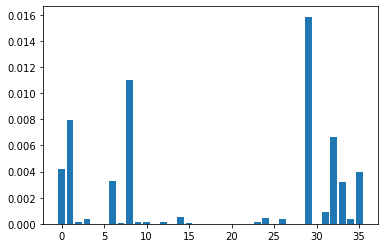

In [25]:
from matplotlib import pyplot

def find_the_best(columns, scores, nlargest = 20):
    dfscores = pd.DataFrame(scores)
    dfcolumns = pd.DataFrame(columns)
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature','Score']  # naming the dataframe columns
    return featureScores.nlargest(nlargest,'Score')  # return best features


importance = model.feature_importance()
print(find_the_best(features.columns,importance))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


In [27]:
# TEST THE MODEL ON TEST DATA
prediction_data = pd.read_csv("out/cleanedDataNoClassOccupation.csv") # USE !pwd command to replace the path of `read_csv` if short ones dont work for you
prediction_before_one_month = pd.read_csv("out/cleaned_Test_2.csv")
prediction_before_two_months = pd.read_csv("out/cleaned_Test_1.csv")
extended_prediction_data = prediction_data
extended_prediction_data["bal_current_account_one_month"] = prediction_before_one_month["bal_current_account"]
extended_prediction_data["bal_current_account_two_month"] = prediction_before_two_months["bal_current_account"]
extended_prediction_data["bal_savings_account_one_month"] = prediction_before_one_month["bal_savings_account"]
extended_prediction_data["bal_savings_account_two_month"] = prediction_before_two_months["bal_savings_account"]
prediction_data_wo_client_id = extended_prediction_data.loc[:, extended_prediction_data.columns != 'client_id']
prediction_data_probs = model.get_test_predict_proba(prediction_data_wo_client_id)
probs = []
for arr in prediction_data_probs:
    probs.append(arr[1])
prediction_data["target"] = probs
prediction_data[["client_id","target"]].to_csv('out/predictions.csv',
                 sep=',', encoding='utf-8', index=False, header=False)

In [8]:
extended_prediction_data

,client_id,homebanking_active,has_homebanking,has_insurance_21,has_insurance_23,has_life_insurance_fixed_cap,has_life_insurance_decreasing_cap,has_fire_car_other_insurance,has_personal_loan,has_mortgage_loan,...,flanders_postal_code,wallonia_postal_code,other_postal_code,customer_occupation_code_0,customer_self_employed,bal_current_account_one_month,bal_current_account_two_month,bal_savings_account_one_month,bal_savings_account_two_month,target
0,ccf4cd93d5c32cd8a59809d54b4d53ac,0,0,0,0,0,0,0,0,1,...,1,0,0,1.000000,0,0.107296,0.083174,0.1038,0.1290,0.003170
1,56605a660d18549592653ff6941186f1,0,0,0,0,0,0,1,0,1,...,1,0,0,1.000000,0,0.048641,0.046367,0.3002,0.3002,0.000457
2,bda5f84c05e5695a7ec10550b457890f,0,0,0,0,0,1,1,0,1,...,1,0,0,1.000000,0,0.204101,0.202677,0.0740,0.0740,0.006344
3,a2f1c04bc3acf2222e658a897400798f,0,0,0,0,0,0,1,0,1,...,0,1,0,1.000000,0,0.215069,0.190249,0.5500,0.5500,0.000115
4,e83aadc3b0d25dbc12a35551afa25807,0,0,0,0,0,0,0,0,0,...,1,0,0,1.000000,1,0.047210,0.044933,0.2038,0.2038,0.008049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27295,1a634b5cfe6dbf35e77ce6519c0e3939,0,0,0,0,0,0,1,0,1,...,1,0,0,1.000000,0,0.327134,0.309273,0.0094,0.0094,0.000710
27296,84b7af2ddbeb919ab238ef7e6a83936c,0,0,0,0,0,0,0,0,0,...,0,1,0,1.000000,0,0.047210,0.044933,0.1308,0.1308,0.000158
27297,c257c09e3f4445d67b52a1007b0205df,0,0,0,0,0,0,0,0,0,...,0,1,0,1.000000,0,0.047210,0.044933,0.4024,0.4024,0.000024
27298,fdd7a1b7e58f642a1fc4867b8f7cdf3a,0,0,0,0,0,0,1,0,1,...,1,0,0,1.000000,0,0.114449,0.108987,0.3956,0.3956,0.001715
